In [1]:
# default_exp utils

# utils

In [1]:
#hide
from nbdev.showdoc import *

In [2]:
import dgl
from dgl import DGLGraph
import pickle as pkl
import sys
import scipy.sparse as sp
import networkx as nx
import torch
from exp.model import GAE, GAEN

Using backend: pytorch


In [3]:
def load_data(dataset):
    # load the data: x, tx, allx, graph
    names = ['x', 'tx', 'allx', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    x, tx, allx, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)
    
    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended


    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    return adj, features

In [4]:
#export
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

In [43]:
_, features = load_data('citeseer')

In [45]:
features = np.array(features.todense(), dtype=np.float32)

In [47]:
dataset = 'citeseer'
names = ['x', 'tx', 'allx', 'graph']
objects = []
for i in range(len(names)):
    with open("data/ind.{}.{}".format(dataset, names[i]), 'rb') as f:
        if sys.version_info > (3, 0):
            objects.append(pkl.load(f, encoding='latin1'))
        else:
            objects.append(pkl.load(f))
x, tx, allx, graph = tuple(objects)

In [48]:
g = DGLGraph(graph)

In [49]:
g.ndata['h'] = features

In [50]:
num_nodes = len(g.nodes())

In [51]:
num_edges = len(g.edges()[0]);num_edges

9228

In [52]:
num_test = int(np.floor(num_edges / 10.))
num_val = int(np.floor(num_edges / 20.))

In [53]:
all_edge_idx = list(range(num_edges))

In [54]:
np.random.shuffle(all_edge_idx)

In [55]:
val_edge_idx = all_edge_idx[:num_val]
test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]

In [56]:
all_edges = g.edges()
all_edges = torch.stack(all_edges, dim=1).numpy()

In [57]:
val_edges = all_edges[val_edge_idx]
test_edges = all_edges[test_edge_idx]

In [58]:
g.remove_edges(val_edge_idx+test_edge_idx)

In [59]:
def ismember(a, b, tol=5):
    rows_close = np.all(np.round(a - b[:,None], tol) == 0, axis=-1)
    return np.any(rows_close)

In [60]:
ismember([2019,973], all_edges)

False

In [61]:
test_edges_false = []

In [62]:
while len(test_edges_false) < len(test_edges):
#     if len(test_edges_false)%200==0:
#         print(len(test_edges_false))
    idx_i = np.random.randint(0, num_nodes)
    idx_j = np.random.randint(0, num_nodes)
    if idx_i == idx_j:
        continue
    if ismember([idx_i, idx_j], all_edges) or ismember([idx_j, idx_i], all_edges):
        continue
    if test_edges_false:
        if ismember([idx_j, idx_i], np.array(test_edges_false)):
            continue
        if ismember([idx_i, idx_j], np.array(test_edges_false)):
            continue
    test_edges_false.append([idx_i, idx_j])

In [63]:
val_edges_false = []

In [64]:
while len(val_edges_false) < len(val_edges):
#     if len(val_edges_false)%200==0:
#         print(len(val_edges_false))
    idx_i = np.random.randint(0, num_nodes)
    idx_j = np.random.randint(0, num_nodes)
    if idx_i == idx_j:
        continue
    if ismember([idx_i, idx_j], all_edges) or ismember([idx_j, idx_i], all_edges):
        continue
    if val_edges_false:
        if ismember([idx_j, idx_i], np.array(test_edges_false)):
            continue
        if ismember([idx_i, idx_j], np.array(test_edges_false)):
            continue
        if ismember([idx_j, idx_i], np.array(val_edges_false)):
            continue
        if ismember([idx_i, idx_j], np.array(val_edges_false)):
            continue
    val_edges_false.append([idx_i, idx_j])

In [65]:
train_edges = torch.stack(g.edges(), dim=1).numpy()

In [66]:
assert ~ismember(test_edges_false, all_edges)
assert ~ismember(val_edges_false, all_edges)
assert ~ismember(val_edges, train_edges)
assert ~ismember(test_edges, train_edges)
assert ~ismember(val_edges, test_edges)

In [67]:
in_feats = features.shape[1];in_feats

3703

In [68]:
from torch.nn.functional import binary_cross_entropy, binary_cross_entropy_with_logits
from sklearn.metrics import roc_auc_score, average_precision_score
from fastprogress.fastprogress import master_bar, progress_bar
import warnings
warnings.filterwarnings('ignore')

In [69]:
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
g.ndata['norm'] = norm.unsqueeze(1)
adj = g.adjacency_matrix().to_dense()
pos_weight = torch.Tensor([float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()])

In [70]:
adj_label = adj.view(-1)
weight_mask = adj_label == 1
weight_tensor = torch.ones(weight_mask.size(0)) 
weight_tensor[weight_mask] = pos_weight

In [71]:
#export
def get_acc(adj_rec, adj_label):
    labels_all = adj_label.view(-1).long()
    preds_all = (adj_rec > 0.5).view(-1).long()
    accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
    return accuracy.item()

In [72]:
def get_scores(edges_pos, edges_neg, adj_rec):    
    preds = [adj_rec[e[0], e[1]] for e in edges_pos]
    preds_neg = [adj_rec[e[0], e[1]] for e in edges_neg]

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [73]:
model = GAEN(in_feats, [32, 16], dropout=0.) 

In [74]:
model = GAE(in_feats, [32,16], dropout=0.)

In [75]:
device = torch.device('cuda: 1')
model = model.to(device)
g = g.to(device)
adj = adj.to(device)
weight_tensor = weight_tensor.to(device)

In [ ]:
loss_function=binary_cross_entropy
losses = []
model.train()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
for e in progress_bar(range(200)):
    adj_logits = model(g)
    optim.zero_grad()
    
    loss = loss_function(adj_logits.view(-1), adj.view(-1), weight=weight_tensor)
    loss.backward()
    optim.step()
    val_roc, val_ap = get_scores(val_edges, val_edges_false, adj_logits)
    losses.append(loss.item())
    print((f'Epoch:{e:2d} loss: {loss.item():.5f} | acc: {get_acc(adj_logits, adj):.5f} | '
           f'val_roc: {val_roc} | val_ap: {val_ap}'))

In [77]:
get_scores(test_edges, test_edges_false, adj_logits)

(0.9293422767632376, 0.9297920949108975)

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

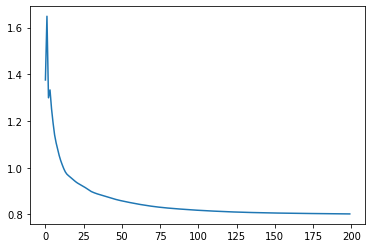

In [79]:
plt.plot(losses)